In [13]:
import numpy as np
import datetime
import sys
import glob
#import rams_tools
import os
import h5py
from collections import OrderedDict
import hdf5plugin
import copy
import pickle
import matplotlib.pyplot as plt
import matplotlib

In [14]:
def grid_decomp(filein,ex_pts,grid_spacing):
    # Grab initial file at the beginning of the analysis period
    rams_file = h5py.File(filein, 'r')

    # Grab lat lon variables from case initial file
    lat = np.array(rams_file['GLAT'])
    lon = np.array(rams_file['GLON'])
    dom_rat = np.shape(lon)[0]/np.shape(lon)[1]

    # Calculate domain size
    ny = np.shape(lat)[0]
    nx = np.shape(lat)[1]

    # Calculate lat lon bounds 
    lat_avg = np.nanmean(lat,axis=1)
    lon_avg = np.nanmean(lon,axis=0)

    # Ignore 100 points near grid boundaries ((exclude 10 km near the boundaries))
    lat0 = lat_avg[ex_pts]
    lat1 = lat_avg[ny-ex_pts]

    lon0 = lon_avg[ex_pts]
    lon1 = lon_avg[nx-ex_pts]

    varns = ['UP','VP','RV','WP','THETA','temp','pres','RTC']
#    varns = []

    lon_arr = np.arange(lon0,lon1+0.1,grid_spacing)
    lat_arr =  np.arange(lat0,lat1+0.1,grid_spacing)

    return lon_avg,lat_avg,lon_arr,lat_arr,lon0,lat0,lon1,lat1,nx,ny


In [15]:
cases = ['RSA1.1-R','ARG1.2-R','BRA1.1-R','BRA1.2-R','AUS1.1-R','DRC1.1-R','PHI1.1-R','PHI2.1-R','WPO1.1-R','USA1.1-R']
subbox = np.array([3,4,5,9,27])
sbid = 4

plotpath = '/tempest/pmarin/monsoon/ENV/Plots/FINAL/'
savepath1 = '/tempest/pmarin/monsoon/ENV/'

plt.rcParams.update({'font.size': 16})


In [16]:
# Calculate Min-Max Scaling (Same as Processing)
varins = 'rh_500s'
#varins = 'mlcapes'
min_val = np.zeros((len(cases),len(subbox)))
max_val = np.zeros((len(cases),len(subbox)))
for c in np.arange(0,len(cases)):
    cn = cases[c]
    savepath = savepath1+cn+'/'
    files = sorted(glob.glob(savepath+'*SubERA5*.p'))
    
    for s in np.arange(0,len(subbox)):
        min_data = 100000
        max_data = 0
        for i in np.arange(0,len(files)):
            SEinfilename = savepath+cn+'_Environments_SubERA5_'+str(i)+'.p'
            with open(SEinfilename, 'rb') as f:
                evars = pickle.load(f) # Load environmental variable dictionary
                var_all = evars[varins]            
                varn = var_all[cn,s]
                min_temp = np.nanmin(varn)
                max_temp = np.nanmax(varn)
                if min_temp < min_data:
                    min_data = min_temp

                if max_temp > max_data:
                    max_data = max_temp

        min_val[c,s] = min_data
        max_val[c,s] = max_data
min_val_2d = np.nanmin(min_val,axis=0)
max_val_2d = np.nanmax(max_val,axis=0)

WPO1.1-R


/tmp/ipykernel_1744142/2624525535.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  lat = np.array(rams_file['GLAT'])
/tmp/ipykernel_1744142/2624525535.py:7: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  lon = np.array(rams_file['GLON'])


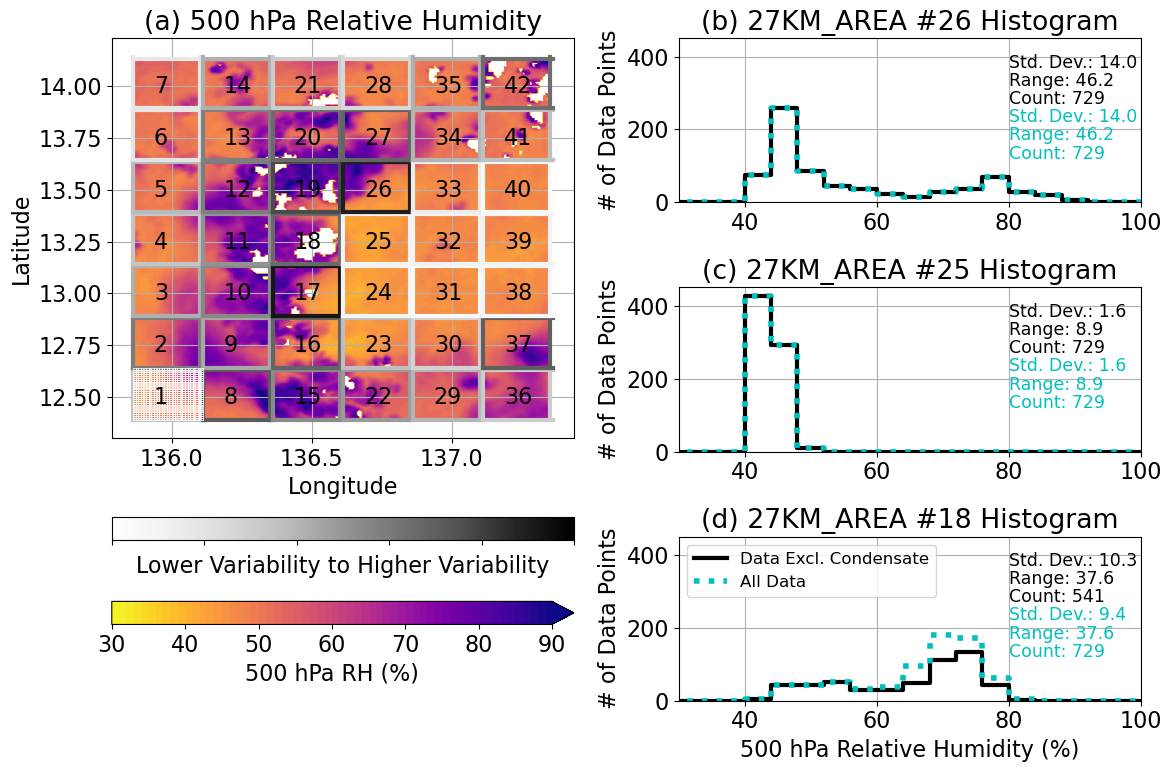

In [17]:
# Figure 02
import matplotlib.gridspec as gridspec
#Update fontsize
plt.rcParams.update({'font.size': 16})


# Make Figure with subplots
fig = plt.figure(figsize=(12,8),tight_layout=True)
gs = gridspec.GridSpec(3, 6)
ax1 = fig.add_subplot(gs[:, 0:3])
axr = OrderedDict()
axr[0] = fig.add_subplot(gs[0, 3:6])
axr[1] = fig.add_subplot(gs[1, 3:6])
axr[2] = fig.add_subplot(gs[2, 3:6])

# choose simulation case
c = 8 # WPO1.1-R; Western Pacific Ocean

# Create path using simulation name
cn = cases[c]
print(cn)  
savepath = savepath1+cn+'/'


# Get filename with saved locations and number of reanalysis grids and subgrids
infilename = savepath1+'Sim_Profs_range_all_100_'+cn+'.p'
with open(infilename, 'rb') as f:
    [profd,latlon,numg,profds,latlons,latlons_id,numgs] = pickle.load(f)    

#get all lite files
files = sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/V0/'+cn+'-V0/G3/out_30s/a-A*g3.h5'))

filein = files[1] # Choose first lite file
gs_reanal = 0.25 # Degrees
stpt = 100 # Shift boxes to remove edges

# Decompose model grid into reanalysis sized boxes
lon_avg,lat_avg,lon_arr,lat_arr,lon0,lat0,lon1,lat1,nx,ny = grid_decomp(filein,stpt,gs_reanal)

# Get subdomain statistics
files = sorted(glob.glob(savepath+'*SubERA5*.p'))

# Create variables for statistics
std_var = np.zeros(len(files))
stdmma_var = np.zeros(len(files))

# Create lat lon arrays for the each of the sub-reanalysis-grid boxes
cur_lat = np.zeros(np.power(subbox[sbid],2))
cur_lon = np.zeros(np.power(subbox[sbid],2))

maplat = []; maplon = []; mapval = []
# Loop through number of subgrids
sgarr = [25,24,17]
sg = OrderedDict()
sg[0] = np.zeros((2,np.power(subbox[sbid],2)))
sg[1] = np.zeros((2,np.power(subbox[sbid],2)))
sg[2] = np.zeros((2,np.power(subbox[sbid],2)))
for i in np.arange(0,numg[cn]):        
    for ii in np.arange(0,subbox[sbid]*subbox[sbid]):
        cur_latlons = latlons[(cn, subbox[sbid], i, ii)]
        cur_lon[ii] = np.nanmean([cur_latlons[0],cur_latlons[1]])
        cur_lat[ii] = np.nanmean([cur_latlons[2],cur_latlons[3]])

    # Load pickle file with all convective parameters calculated on the sub-reanalysis-grid boxes
    SEinfilename = savepath+cn+'_Environments_SubERA5_'+str(i)+'.p'
    plt_lim = [30,90]
    with open(SEinfilename, 'rb') as f:
        evars = pickle.load(f) # Load environmental variable dictionary
        var_all = evars['rh_500s']            
        scr_all = evars['c_500s']  

        for s in np.arange(sbid,sbid+1): # Subbox 3 = 3km, 4 = 1km
            varn = var_all[cn,s]
            varn = np.abs(varn)
            for ii in np.arange(0,len(sgarr)):
                if i == sgarr[ii]:
                    sg[ii][0,:] = copy.deepcopy(varn)

            varn[scr_all[cn,s] > 0.00001] = np.nan

            for ii in np.arange(0,len(sgarr)):
                if i == sgarr[ii]:
                    sg[ii][1,:] = copy.deepcopy(varn)

            # Count Sample Size within Each Reanalysis Box
            cnt_save = np.count_nonzero(~np.isnan(varn))
            #print(cnt_save)

            # Calculate Min-Max scaled Standard Deviation
            std_var[i] = np.nanstd(varn)
            varn_mma = (varn-min_val_2d[s])/(max_val_2d[s]-min_val_2d[s])
            stdmma_var[i] = np.nanstd(varn_mma)
            varn[scr_all[cn,s] > 0.00001] = 0
            #print(i,stdmma_var[i])
            #print(len(varn))

    # Append data for each reanalysis box
    maplat = np.append(maplat,cur_lat)
    maplon = np.append(maplon,cur_lon)
    mapval = np.append(mapval,varn)

# Create line scaling array
cvals = np.zeros(len(stdmma_var))
for c in np.arange(0,len(stdmma_var)):
    cvals[c] = (stdmma_var[c]-0.0)/(0.15-0.0)
    if cvals[c] > 1.0:
        cvals[c] = 1.0

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","thistle","plum", "violet","magenta"])
cmap = plt.cm.Greys
bar_colors = [cmap(c) for c in cvals]    

# Variable for plotting
rams_file = h5py.File(filein, 'r')

#    cp = 1004; # J/kg/K
#    rd = 287; # J/kg/K
#    p00 = 100000; # Reference Pressure
#    temp_arr = p00 * np.power( (rams_file['PI'][:] / cp), cp/rd)
#    avg_prof = np.nanmean(temp_arr,axis=(1,2))
#    print(avg_prof)
#    id500 = np.where(np.abs(avg_prof-50000)==np.min(np.abs(avg_prof-50000)))[0][0]

#    plt_var = rams_file['RV'][id500,:,:]*1000 
lat = rams_file['GLAT'][:]
lon = rams_file['GLON'][:]
rams_file.close()

dom_rat = np.shape(lon)[0]/np.shape(lon)[1]

plt_var = mapval*100
lon = maplon
lat = maplat    

# Make Plot
import matplotlib.colors as mcolors
cmap_use = plt.cm.plasma_r(np.linspace(0, 1, 256))
cmap_use[0,:] = 1
cmap_use = mcolors.LinearSegmentedColormap.from_list('colormap', cmap_use)

w_lvls = 100
#a = ax.contourf(lon,lat,plt_var,levels=w_lvls,cmap=plt.cm.viridis,extend='both')    
a = ax1.tricontourf(lon,lat,plt_var,levels=w_lvls,cmap=cmap_use,vmin=plt_lim[0],vmax=plt_lim[1],extend='max')
cbar = plt.colorbar(a,ax=ax1,orientation="horizontal",pad=0.0)
cbar.ax.set_xlim(plt_lim)   
cbar.ax.set_xlabel('500 hPa RH (%)')

dd = 0.01
lw = 3.0
cntp = 1 # Need to subtract 1 from indicies using python numbering from 0
# loop through lat and lon regions
for lo in np.arange(0,len(lon_arr)-1):
    for la in np.arange(0,len(lat_arr)-1):

        ax1.plot([lon_arr[lo],lon_arr[lo]],[lat_arr[la],lat_arr[la+1]],'-',lw=lw,c=bar_colors[cntp-1])
        ax1.plot([lon_arr[lo],lon_arr[lo+1]],[lat_arr[la],lat_arr[la]],'-',lw=lw,c=bar_colors[cntp-1])
        ax1.plot([lon_arr[lo+1]-dd,lon_arr[lo+1]-dd],[lat_arr[la],lat_arr[la+1]],'-',lw=lw,c=bar_colors[cntp-1])
        ax1.plot([lon_arr[lo],lon_arr[lo+1]],[lat_arr[la+1]-dd,lat_arr[la+1]-dd],'-',lw=lw,c=bar_colors[cntp-1])

        lon_id0 = np.where(np.abs(lon_avg-lon_arr[lo]) == np.min(np.abs(lon_avg-lon_arr[lo])))[0][0]
        lon_id1 = np.where(np.abs(lon_avg-lon_arr[lo+1]) == np.min(np.abs(lon_avg-lon_arr[lo+1])))[0][0]
        lat_id0 = np.where(np.abs(lat_avg-lat_arr[la]) == np.min(np.abs(lat_avg-lat_arr[la])))[0][0]
        lat_id1 = np.where(np.abs(lat_avg-lat_arr[la+1]) == np.min(np.abs(lat_avg-lat_arr[la+1])))[0][0]
        lon_plot = np.nanmean([lon_avg[lon_id0],lon_avg[lon_id1]])
        lat_plot = np.nanmean([lat_avg[lat_id0],lat_avg[lat_id1]])
        ax1.text(lon_plot-0.05,lat_plot-0.05,str(cntp))
        cntp = cntp + 1

box_id = 27
## Plot 3km boxes within reanalysis boxes for one chosen box
for i in np.arange(0,box_id*box_id):
    llp = latlons[cn,box_id,0,i]
    ax1.plot([llp[0],llp[0]],[llp[2],llp[3]],'-w',lw=0.5)
    ax1.plot([llp[1],llp[1]],[llp[2],llp[3]],'-w',lw=0.5)
    ax1.plot([llp[0],llp[1]],[llp[2],llp[2]],'-w',lw=0.5)
    ax1.plot([llp[0],llp[1]],[llp[3],llp[3]],'-w',lw=0.5)        
        
sm = plt.cm.ScalarMappable(cmap=cmap)
cbar_lines = plt.colorbar(sm,ax=ax1,orientation="horizontal",pad=0.14)
cbar_lines.ax.set_xlabel('Lower Variability to Higher Variability')
cbar_lines.ax.set_xticklabels('')

ax1.grid()
ax1.set_ylabel('Latitude')
ax1.set_xlabel('Longitude')
ax1.set_title('(a) 500 hPa Relative Humidity')


titlbls = ['(b) ','(c) ','(d) ']
for ii in np.arange(0,3):
    bins = np.arange(0,100.1,4)
    
    histval,bins = np.histogram(sg[ii][1,:]*100,bins=bins)
    histval = np.insert(histval,0,0)
    axr[ii].step(bins,histval,'-k',lw=3,label='Data Excl. Condensate')

    histval,bins = np.histogram(sg[ii][0,:]*100,bins=bins)
    histval = np.insert(histval,0,0)
    axr[ii].step(bins,histval,':c',lw=4,label='All Data')
    
    avg0 = np.nanmean(sg[ii][0,:]*100)
    avg1 = np.nanmean(sg[ii][1,:]*100)

    std0 = np.nanstd(sg[ii][0,:]*100)
    std1 = np.nanstd(sg[ii][1,:]*100)

    ran0 = np.nanmax(sg[ii][0,:]*100)-np.nanmin(sg[ii][0,:]*100)
    ran1 = np.nanmax(sg[ii][1,:]*100)-np.nanmin(sg[ii][1,:]*100)
    
    cnt0 = np.count_nonzero(~np.isnan(sg[ii][0,:]*100))
    cnt1 = np.count_nonzero(~np.isnan(sg[ii][1,:]*100))

    
    axr[ii].text(80,370,'Std. Dev.: '+str(np.round(std1,1)),c='k',size=12.5)
    axr[ii].text(80,320,'Range: '+str(np.round(ran1,1)),c='k',size=12.5)
    axr[ii].text(80,270,'Count: '+str(np.round(cnt1,0)),c='k',size=12.5)
    axr[ii].text(80,220,'Std. Dev.: '+str(np.round(std0,1)),c='c',size=12.5)
    axr[ii].text(80,170,'Range: '+str(np.round(ran0,1)),c='c',size=12.5)
    axr[ii].text(80,120,'Count: '+str(np.round(cnt0,0)),c='c',size=12.5)
    
    
    axr[ii].set_ylim([0,450])
    axr[ii].set_title(titlbls[ii]+'27KM_AREA #'+str(int(sgarr[ii]+1))+' Histogram')
    axr[ii].set_xlim([30,100])
    axr[ii].set_ylabel('# of Data Points')
    axr[ii].grid()
    
axr[2].set_xlabel('500 hPa Relative Humidity (%)')
axr[2].legend(fontsize=12,loc='upper left')

plt.tight_layout()
#Save file 
savefile = plotpath+'Figure02.pdf'
fig.savefig(savefile)
savefile = plotpath+'Figure02.png'
fig.savefig(savefile)

In [8]:
plotpath

'/tempest/pmarin/monsoon/ENV/Plots/FINAL/'